### Setup

In [2]:
import sys
sys.path.append('../')
from src.load_data import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [3]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [4]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [5]:
TEST_YEAR = 2019

In [6]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

# Load best model

In [7]:
params = get_best_parameters('lightgbm-simple-cv-test', 'lightgbm')

WIS of best run: 185.67070007218177


In [8]:
params

{'lags': 16,
 'model': 'lightgbm',
 'max_bin': 1024,
 'max_depth': 5,
 'reg_alpha': 0,
 'subsample': 1,
 'test_year': 2019,
 'num_leaves': 40,
 'reg_lambda': 0,
 'n_estimators': 5000,
 'use_encoders': True,
 'use_features': False,
 'learning_rate': 0.05,
 'min_split_gain': 0,
 'subsample_freq': 0,
 'use_covariates': True,
 'multiple_series': False,
 'colsample_bytree': 1,
 'min_child_samples': 30,
 'lags_past_covariates': 8,
 'use_static_covariates': True,
 'lags_future_covariates': [0, 4]}

In [9]:
name = params.pop('model')
test_year = params.pop('test_year')
multiple_series = params.pop('multiple_series')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')

In [10]:
if not use_covariates:
    del params['lags_past_covariates']

In [11]:
model = LightGBMModel(
    **params,
    output_chunk_length=HORIZON,
    add_encoders=ENCODERS if use_encoders else None,
    likelihood="quantile",
    quantiles=QUANTILES,
    verbose=-1
)

# Load data

In [12]:
sources =  ['icosari', 'agi']

In [13]:
targets_train, targets_validation, covariates = get_test_data(TEST_YEAR, sources)

In [14]:
validation_start = targets_train.end_time() + targets_train.freq

In [15]:
covariates = covariates if use_covariates else None

<Axes: xlabel='date'>

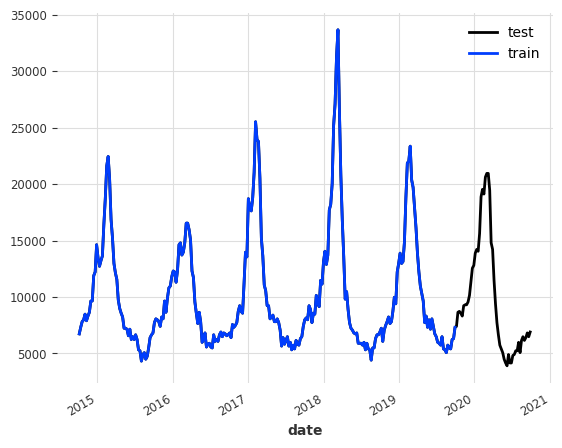

In [16]:
targets_validation['icosari-sari-DE'].plot(label='test')
targets_train['icosari-sari-DE'].plot(label='train')

# Train model

In [20]:
RANDOM_SEEDS = [1, 2, 3, 4, 5] # , 6, 7, 8, 9, 10]

In [21]:
for seed in RANDOM_SEEDS:
    print(seed)
    model_path = f'../models/pre-covid/{name}-{test_year}-{seed}.pt'
    hfc_path = f'../data/pre-covid/submodels/{name}-{test_year}-{seed}.csv'
    
    model.model_params['random_state'] = seed
    model.fit(targets_train, past_covariates=covariates)
    model.save(model_path)
    
    hfc = model.historical_forecasts(
        series=targets_validation,
        past_covariates=covariates,
        start=validation_start,
        forecast_horizon=HORIZON,
        stride=1,
        last_points_only=False,
        retrain=False,
        verbose=False,
        num_samples=NUM_SAMPLES,
        enable_optimization=False
    )
    
    df = reshape_hfc(hfc)
    df.to_csv(hfc_path, index=False)

1
2
3
4
5


# Compute ensemble

In [22]:
files = glob.glob(f'../data/pre-covid/submodels/{name}-{test_year}-*.csv')

In [23]:
files

['../data/pre-covid/submodels/lightgbm-2019-2.csv',
 '../data/pre-covid/submodels/lightgbm-2019-1.csv',
 '../data/pre-covid/submodels/lightgbm-2019-3.csv',
 '../data/pre-covid/submodels/lightgbm-2019-5.csv',
 '../data/pre-covid/submodels/lightgbm-2019-4.csv']

In [35]:
dfs = [pd.read_csv(file, parse_dates=['forecast_date', 'target_end_date']) for file in files]

In [36]:
df = pd.concat(dfs)

In [26]:
df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

In [27]:
df.to_csv(f'../data/pre-covid/{name}_ensemble-{test_year}.csv', index=False)

In [37]:
df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'median'}).reset_index()

In [38]:
df.to_csv(f'../data/pre-covid/{name}_median_ensemble-{test_year}.csv', index=False)

# Plot forecasts

In [28]:
df_plot = prepare_plot_data(df, targets_validation[validation_start : ])

### Mean ensemble

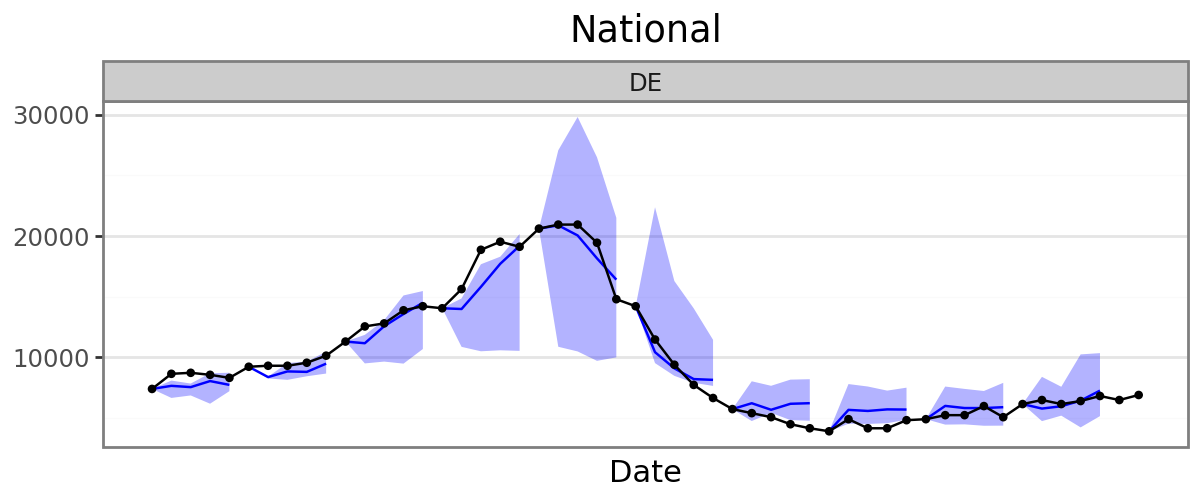

In [29]:
plot_forecasts(df_plot, 'national', start=1)

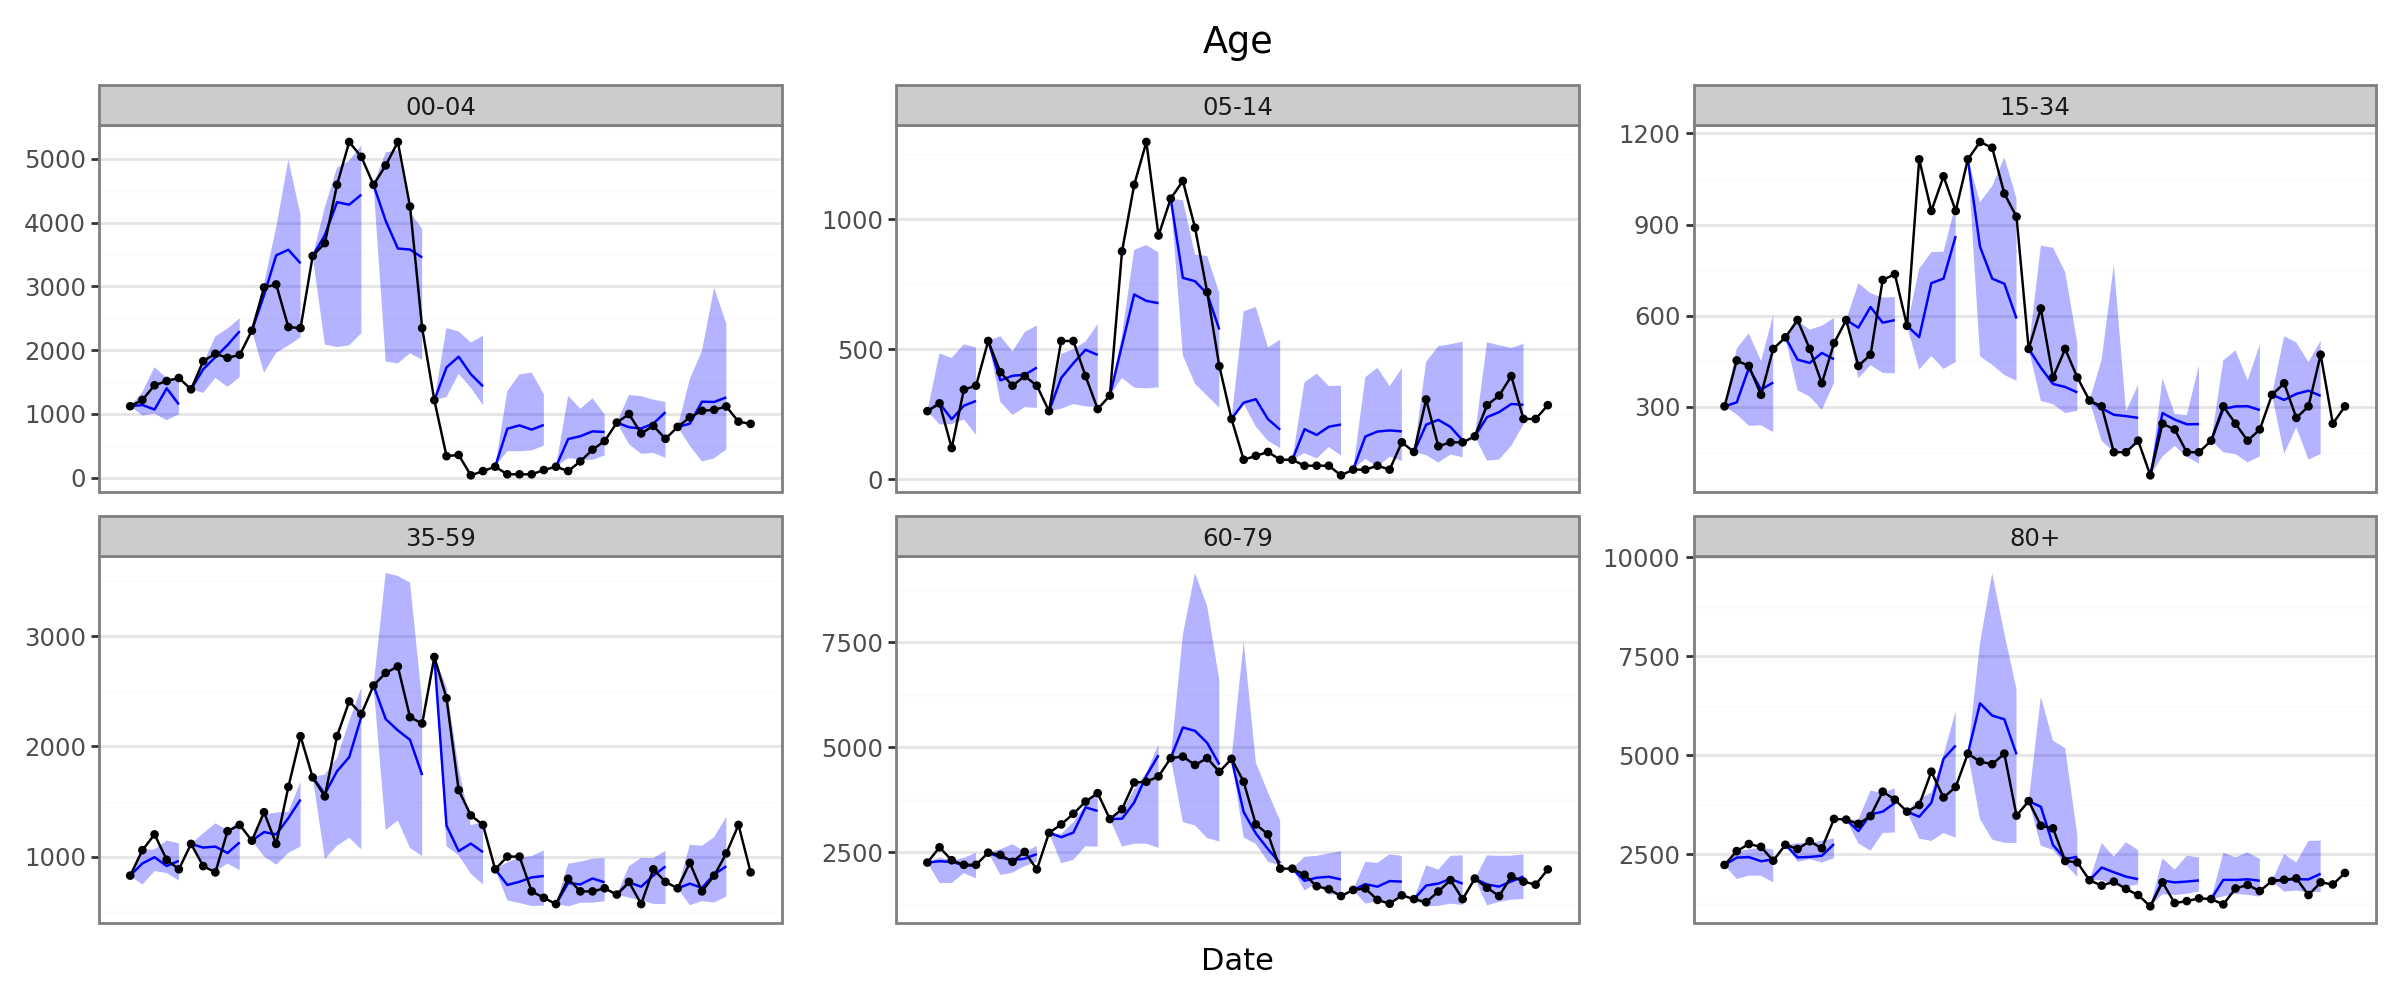

In [30]:
plot_forecasts(df_plot, 'age', start=1)

### Median ensemble

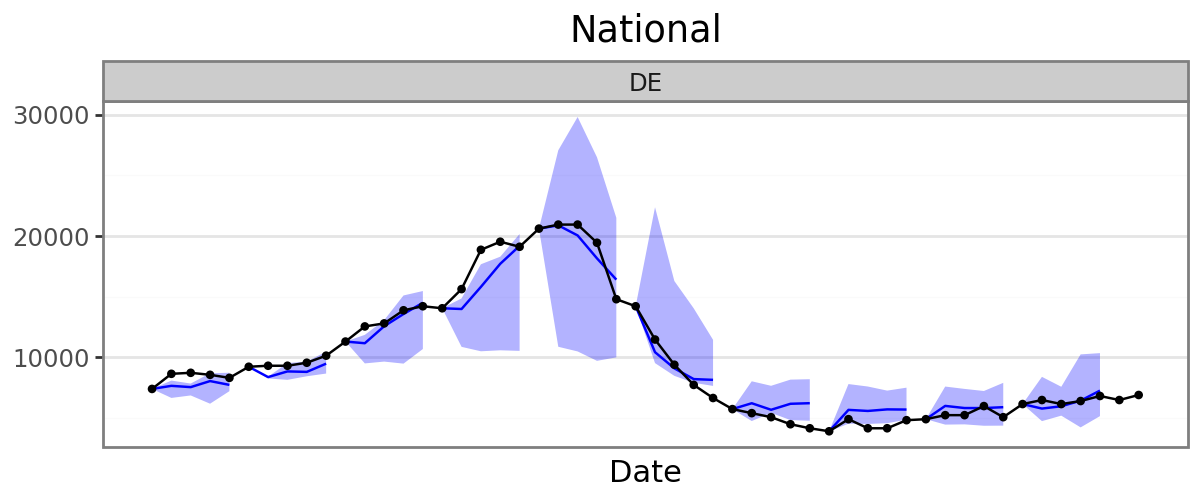

In [39]:
plot_forecasts(df_plot, 'national', start=1)

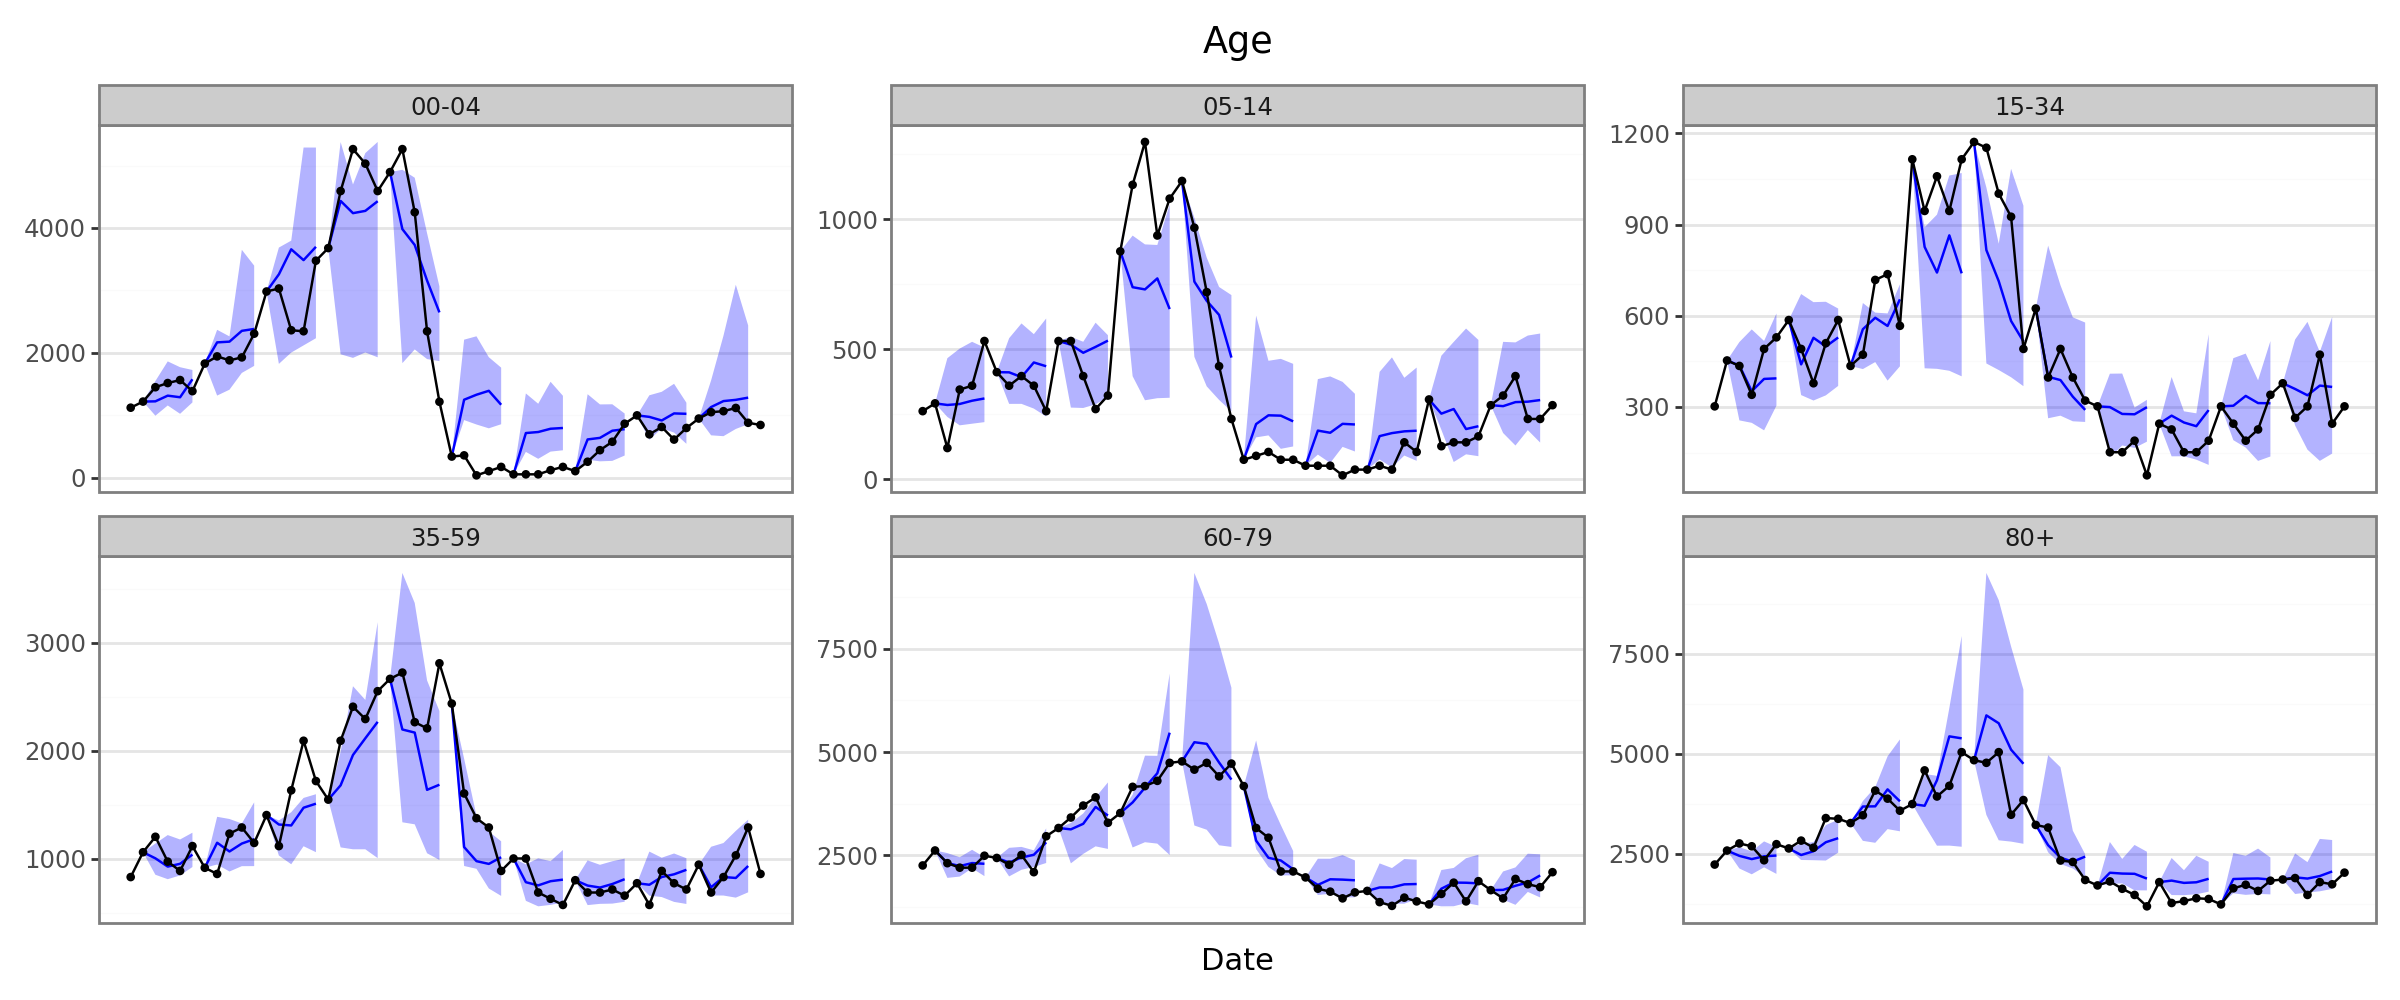

In [41]:
plot_forecasts(df_plot, 'age', start=2)